# RAMP on Detecting Attacks on an Industrial Water System from Its Operational Status

Laurent Pipitone (CentraleSupélec Student / Master IAC)

## Introduction

This notebook focuses on the detection of cyber attacks within critical industrial systems using the BATtle of Attack Detection Algorithms (BaTaDal) dataset. The BaTaDal dataset simulates various scenarios of cyber incidents in a water distribution network named C-Town. The aim of this project is to build and evaluate machine learning models capable of distinguishing between normal operation periods and those affected by cyber attacks, using only sensor data from the industrial environment.

### Dataset Description

The BaTaDal dataset comprises data collected over multiple time periods, including both normal operations and periods where cyber attacks were simulated. The data captures measurements from various sensors and actuators, such as water levels, pump statuses, and flow rates, which are critical for the operation of the water distribution system. The dataset contains two main parts:

- **Training Dataset 1**: A one-year long simulation of normal operations without any cyber attacks.
- **Training Dataset 2**: A six-month long simulation containing various cyber attacks, including replay attacks, data injections, and modifications of control signals. The attacks are labeled, making it suitable for supervised learning tasks.
- **Attacks list 2**: A detailed list of known attacks (and attacks date & duration) on the Industrial System, that occured during the **Training Dataset 2**.

### Objective

The objective of this analysis is to explore the potential of using sensor data to detect cyber attacks in industrial control systems (ICS). Specifically, we aim to address the following questions:
- Can machine learning models accurately distinguish between normal and attack scenarios using only sensor data?
- Which features (e.g., water levels, pump flows) are most indicative of a cyber attack?
- How do different models perform in terms of detecting attack instances, and what are their strengths and limitations?

### Structure of the Notebook

1. **Data Loading and Preprocessing**: Import the necessary libraries, load the dataset, and preprocess the data for analysis.
2. **Exploratory Data Analysis (EDA)**: Understand the distributions, correlations, and potential patterns in the data, both in normal and attack scenarios.
3. **Feature Engineering**: Create and transform features to enhance model performance.
4. **Model Training**: Train various classification models to detect cyber attacks.
5. **Model Evaluation**: Assess the performance of the models using appropriate metrics and visualize the results.
6. **Conclusion**: Summarize findings and suggest potential improvements for future research.

## Manipulating the data
### Loading and cleaning the data with pandas

In [87]:
import pandas as pd

# Load the datasets with the specified file paths
batadal_data_path = './BATADAL_dataset04.csv'
attacks_info_path = './Attacks_TrainingDataset2.csv'

# Read the data into pandas DataFrames
batadal_data_wth_attack = pd.read_csv(batadal_data_path)
batadal_attacks_info = pd.read_csv(attacks_info_path)


Since we hit some key reference issues, we also investigated columns of the batadal_attacks_info dataframe

In [88]:
print([repr(col) for col in batadal_data_wth_attack.columns])
print("\n")
print([repr(col) for col in batadal_attacks_info.columns])

["'DATETIME'", "' L_T1'", "' L_T2'", "' L_T3'", "' L_T4'", "' L_T5'", "' L_T6'", "' L_T7'", "' F_PU1'", "' S_PU1'", "' F_PU2'", "' S_PU2'", "' F_PU3'", "' S_PU3'", "' F_PU4'", "' S_PU4'", "' F_PU5'", "' S_PU5'", "' F_PU6'", "' S_PU6'", "' F_PU7'", "' S_PU7'", "' F_PU8'", "' S_PU8'", "' F_PU9'", "' S_PU9'", "' F_PU10'", "' S_PU10'", "' F_PU11'", "' S_PU11'", "' F_V2'", "' S_V2'", "' P_J280'", "' P_J269'", "' P_J300'", "' P_J256'", "' P_J289'", "' P_J415'", "' P_J302'", "' P_J306'", "' P_J307'", "' P_J317'", "' P_J14'", "' P_J422'", "' ATT_FLAG'"]


["'ID'", "'Starting time [dd/mm/YY HH]'", "'Ending time [dd/mm/YY HH]'", "'Duration [hours]'", "'Attack description'", "'SCADA concealment'", "'Labeled [hours]'"]


We need to fix the ATT_FLAG column (and all columns for that matter... not taking any chances...)
Some columns have too complex names with special caracters.

In [89]:
# Strip any leading/trailing spaces in column names
batadal_data_wth_attack.columns = batadal_data_wth_attack.columns.str.strip()

# Rename columns to simplify access
batadal_attacks_info.rename(columns={
    'Starting time [dd/mm/YY HH]': 'Start_Time',
    'Ending time [dd/mm/YY HH]': 'End_Time'
}, inplace=True)

print([repr(col) for col in batadal_data_wth_attack.columns])
print("\n")
print([repr(col) for col in batadal_attacks_info.columns])

["'DATETIME'", "'L_T1'", "'L_T2'", "'L_T3'", "'L_T4'", "'L_T5'", "'L_T6'", "'L_T7'", "'F_PU1'", "'S_PU1'", "'F_PU2'", "'S_PU2'", "'F_PU3'", "'S_PU3'", "'F_PU4'", "'S_PU4'", "'F_PU5'", "'S_PU5'", "'F_PU6'", "'S_PU6'", "'F_PU7'", "'S_PU7'", "'F_PU8'", "'S_PU8'", "'F_PU9'", "'S_PU9'", "'F_PU10'", "'S_PU10'", "'F_PU11'", "'S_PU11'", "'F_V2'", "'S_V2'", "'P_J280'", "'P_J269'", "'P_J300'", "'P_J256'", "'P_J289'", "'P_J415'", "'P_J302'", "'P_J306'", "'P_J307'", "'P_J317'", "'P_J14'", "'P_J422'", "'ATT_FLAG'"]


["'ID'", "'Start_Time'", "'End_Time'", "'Duration [hours]'", "'Attack description'", "'SCADA concealment'", "'Labeled [hours]'"]


We see that Starting time [dd/mm/YY HH], Ending time [dd/mm/YY HH] and DATETIME columns should be dates instead of strings/objects. We can use pandas to convert this data.

In [90]:
# Convert 'DATETIME' columns to datetime format for easy comparison
batadal_data_wth_attack['DATETIME'] = pd.to_datetime(
    batadal_data_wth_attack['DATETIME'], 
    format='%d/%m/%y %H', 
    dayfirst=True, 
    errors='coerce'
)
batadal_data_wth_attack.iloc[:, [0, 1, 20, 25, 44]].info()

batadal_attacks_info['Start_Time'] = pd.to_datetime(
    batadal_attacks_info['Start_Time'], 
    format='%d/%m/%Y %H', 
    dayfirst=True, 
    errors='coerce'
)
batadal_attacks_info['End_Time'] = pd.to_datetime(
    batadal_attacks_info['End_Time'], 
    format='%d/%m/%Y %H', 
    dayfirst=True, 
    errors='coerce'
)
print("\n")
batadal_attacks_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4177 entries, 0 to 4176
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   DATETIME  4177 non-null   datetime64[ns]
 1   L_T1      4177 non-null   float64       
 2   F_PU7     4177 non-null   float64       
 3   S_PU9     4177 non-null   float64       
 4   ATT_FLAG  4177 non-null   int64         
dtypes: datetime64[ns](1), float64(3), int64(1)
memory usage: 163.3 KB


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7 entries, 0 to 6
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   ID                  7 non-null      int64         
 1   Start_Time          7 non-null      datetime64[ns]
 2   End_Time            7 non-null      datetime64[ns]
 3   Duration [hours]    7 non-null      int64         
 4   Attack description  7 non-null      object        
 5   SC

In [91]:
# Display the metadata
batadal_data_wth_attack.iloc[:, [0, 1, 20, 25, 44]].info()
print("\n")
batadal_attacks_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4177 entries, 0 to 4176
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   DATETIME  4177 non-null   datetime64[ns]
 1   L_T1      4177 non-null   float64       
 2   F_PU7     4177 non-null   float64       
 3   S_PU9     4177 non-null   float64       
 4   ATT_FLAG  4177 non-null   int64         
dtypes: datetime64[ns](1), float64(3), int64(1)
memory usage: 163.3 KB


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7 entries, 0 to 6
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   ID                  7 non-null      int64         
 1   Start_Time          7 non-null      datetime64[ns]
 2   End_Time            7 non-null      datetime64[ns]
 3   Duration [hours]    7 non-null      int64         
 4   Attack description  7 non-null      object        
 5   SC

### Adding attack on water water tanks booleans / categories for better exploitability

In [92]:
# Add columns T1_attack to T7_attack based on "Attack description" and "SCADA concealment" columns

# Create T1_attack to T7_attack columns initialized with 0
for i in range(1, 8):
    batadal_attacks_info[f'T{i}_attack'] = 0

# Set the columns to 1 if string "T1" to "T7" is mentioned in "Attack description" or "SCADA concealment"
for i in range(1, 8):
    water_tank_str = f'T{i}'
    batadal_attacks_info[f'T{i}_attack'] = batadal_attacks_info.apply(
        lambda row: 1 if (water_tank_str in str(row['Attack description']) or water_tank_str in str(row['SCADA concealment'])) else 0,
        axis=1
    )

batadal_attacks_info.head(5)

,ID,Start_Time,End_Time,Duration [hours],Attack description,SCADA concealment,Labeled [hours],T1_attack,T2_attack,T3_attack,T4_attack,T5_attack,T6_attack,T7_attack
0,1,2016-09-13 23:00:00,2016-09-16 00:00:00,50,Attacker changes L_T7 thresholds (which contro...,Replay attack on L_T7.,42,0,0,0,0,0,0,1
1,2,2016-09-26 11:00:00,2016-09-27 10:00:00,24,Like Attack #1 but replay attack extended to P...,Replay attack L_T7 on PU10/PU11 flow and status.,0,0,0,0,0,0,0,1
2,3,2016-10-09 09:00:00,2016-10-11 20:00:00,60,Attack alters L_T1 readings sent by PLC2 to PL...,Polyline to offset L_T1 increase.,60,1,0,0,0,0,0,0
3,4,2016-10-29 19:00:00,2016-11-02 16:00:00,94,Like Attack #3.,"Replay attack on L_T1, PU1/PU2 flow and status...",37,1,0,0,0,0,0,0
4,5,2016-11-26 17:00:00,2016-11-29 04:00:00,60,Working speed of PU7 reduced to 0.9 of nominal...,None.,7,0,0,0,1,0,0,0


### Fixing data inconsistencies

Now, let's compare our batadal_data_wth_attack and batadal_attacks_info

,ID,Start_Time,End_Time,Duration [hours],Attack description,SCADA concealment,Labeled [hours],T1_attack,T2_attack,T3_attack,T4_attack,T5_attack,T6_attack,T7_attack
0,1,2016-09-13 23:00:00,2016-09-16 00:00:00,50,Attacker changes L_T7 thresholds (which contro...,Replay attack on L_T7.,42,0,0,0,0,0,0,1
1,2,2016-09-26 11:00:00,2016-09-27 10:00:00,24,Like Attack #1 but replay attack extended to P...,Replay attack L_T7 on PU10/PU11 flow and status.,0,0,0,0,0,0,0,1
2,3,2016-10-09 09:00:00,2016-10-11 20:00:00,60,Attack alters L_T1 readings sent by PLC2 to PL...,Polyline to offset L_T1 increase.,60,1,0,0,0,0,0,0
3,4,2016-10-29 19:00:00,2016-11-02 16:00:00,94,Like Attack #3.,"Replay attack on L_T1, PU1/PU2 flow and status...",37,1,0,0,0,0,0,0
4,5,2016-11-26 17:00:00,2016-11-29 04:00:00,60,Working speed of PU7 reduced to 0.9 of nominal...,None.,7,0,0,0,1,0,0,0


In [ ]:
# Display the attack info
batadal_attacks_info.head(5)

In [94]:
attack_start = pd.to_datetime(batadal_attacks_info['Start_Time'][1], format='%d/%m/%Y %H')
attack_end = pd.to_datetime(batadal_attacks_info['End_Time'][1], format='%d/%m/%Y %H')

# Filtrer les données de batadal_data_wth_attack pour afficher la période spécifiée
filtered_data = batadal_data_wth_attack[
    (batadal_data_wth_attack['DATETIME'] >= attack_start) & 
    (batadal_data_wth_attack['DATETIME'] <= attack_end)
]

# Display the batadal data containing attacks
filtered_data.iloc[:, [0, 1, 20, 25, 44]].head(5)

,DATETIME,L_T1,F_PU7,S_PU9,ATT_FLAG
2027,2016-09-26 11:00:00,1.89,50.72,0.0,-999
2028,2016-09-26 12:00:00,2.01,50.72,0.0,-999
2029,2016-09-26 13:00:00,1.92,49.42,0.0,-999
2030,2016-09-26 14:00:00,1.88,49.97,0.0,-999
2031,2016-09-26 15:00:00,1.86,49.71,0.0,-999


One can clearly see the ATT_FLAG is poorly set / incomplete compared to the period of known attacks. Since the batadal_data_wth_attack is improperly flagged (when under attack, which we know from batadal_attacks_info), we will replace the "-999" value by a assumed_positive_row_marker (float 0 <= f <= 1) value, otherwise by 0, to be able to actually learn/distinguish attacks from the data.

We will also enrich the batadal_data_wth_attack with new features T1_ATT_FLAG ... T7_ATT_FLAG whenever T1 or ... T7 is under attack.

In [95]:
assumed_positive_row_marker = 0.75

# Convert column 'ATT_FLAG' toward type float64 before modifying
batadal_data_wth_attack['ATT_FLAG'] = batadal_data_wth_attack['ATT_FLAG'].astype(float)

# Initialize T1_ATT_FLAG to T7_ATT_FLAG columns with 0
for i in range(1, 8):
    batadal_data_wth_attack[f'T{i}_ATT_FLAG'] = 0.0

# Loop through each attack period and set ATT_FLAG and T1_ATT_FLAG to T7_ATT_FLAG
for index, row in batadal_attacks_info.iterrows():
    # Extract start and end of the attack period from the attacks dataset
    attack_start = pd.to_datetime(row['Start_Time'], format='%d/%m/%Y %H')
    attack_end = pd.to_datetime(row['End_Time'], format='%d/%m/%Y %H')
    
    # Set T1_ATT_FLAG to T7_ATT_FLAG for known attack periods in a single loop
    for i in range(1, 8):
        if row[f'T{i}_attack'] == 1:
            batadal_data_wth_attack.loc[
                (batadal_data_wth_attack['DATETIME'] >= attack_start) &
                (batadal_data_wth_attack['DATETIME'] <= attack_end),
                f'T{i}_ATT_FLAG'
            ] = batadal_data_wth_attack.apply(
                lambda x: 1 if x['ATT_FLAG'] == 1 else assumed_positive_row_marker, axis=1
            )
    
    # Update ATT_FLAG for known attack periods
    batadal_data_wth_attack.loc[
        (batadal_data_wth_attack['DATETIME'] >= attack_start) &
        (batadal_data_wth_attack['DATETIME'] <= attack_end) & 
        (batadal_data_wth_attack['ATT_FLAG'] == -999),
        'ATT_FLAG'
    ] = assumed_positive_row_marker

# Update ATT_FLAG for non-attack periods (everything else remaining)
    batadal_data_wth_attack.loc[
        (batadal_data_wth_attack['ATT_FLAG'] == -999),
        'ATT_FLAG'
    ] = 0

# Provide a sample for verification (T7 attack in row 0 of batadal_attacks_info)
attack_start_T7 = pd.to_datetime(batadal_attacks_info['Start_Time'][0], format='%d/%m/%Y %H')
attack_end_T7 = pd.to_datetime(batadal_attacks_info['End_Time'][0], format='%d/%m/%Y %H')

# Filtrer les données de batadal_data_wth_attack pour afficher la période spécifiée
filtered_data = batadal_data_wth_attack[
    (batadal_data_wth_attack['DATETIME'] >= attack_start_T7) & 
    (batadal_data_wth_attack['DATETIME'] <= attack_end_T7)
]

# Display the batadal data containing attacks
filtered_data.iloc[:, [0, 1, 20, 25] + list(range(44, 52))].head(5)


,DATETIME,L_T1,F_PU7,S_PU9,ATT_FLAG,T1_ATT_FLAG,T2_ATT_FLAG,T3_ATT_FLAG,T4_ATT_FLAG,T5_ATT_FLAG,T6_ATT_FLAG,T7_ATT_FLAG
1727,2016-09-13 23:00:00,3.51,48.43,0.0,0.75,0.0,0.0,0.0,0.0,0.0,0.0,0.75
1728,2016-09-14 00:00:00,3.66,47.71,0.0,0.75,0.0,0.0,0.0,0.0,0.0,0.0,0.75
1729,2016-09-14 01:00:00,3.84,46.76,0.0,0.75,0.0,0.0,0.0,0.0,0.0,0.0,0.75
1730,2016-09-14 02:00:00,3.81,48.43,0.0,0.75,0.0,0.0,0.0,0.0,0.0,0.0,0.75
1731,2016-09-14 03:00:00,3.75,48.40,0.0,1.00,0.0,0.0,0.0,0.0,0.0,0.0,1.00


## Visualizing data
### All the water tanks and global attacks

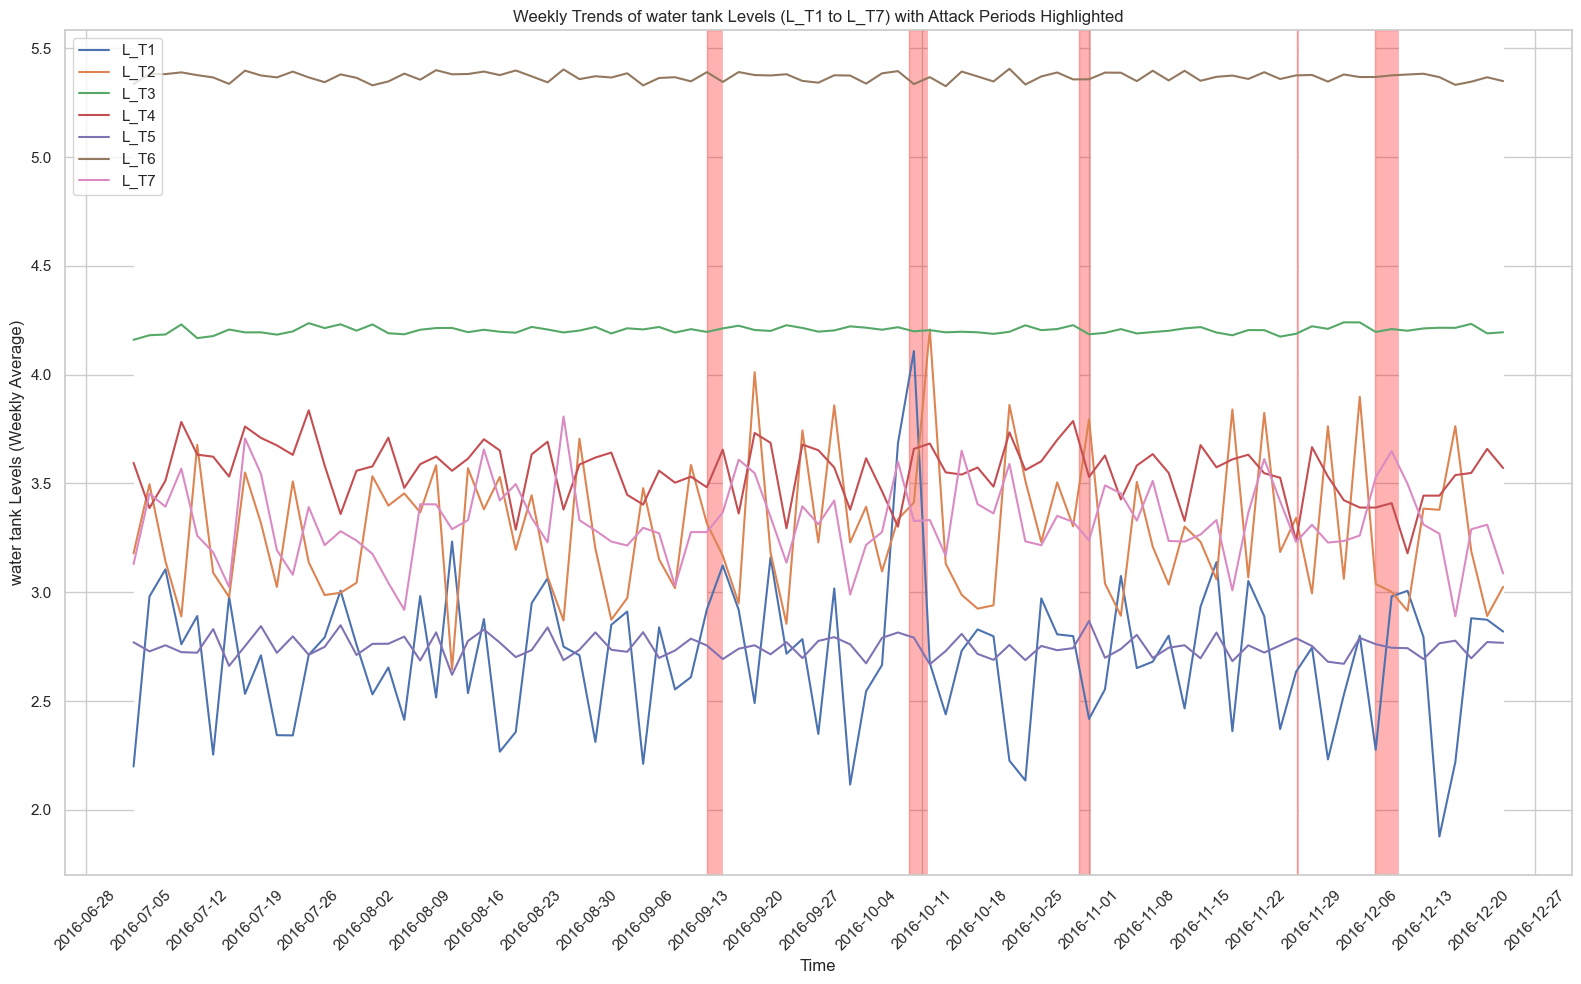

In [96]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import matplotlib.dates as mdates

# Resample the data every 2 day and take the mean, excluding the last period to avoid incomplete data
weekly_data = batadal_data_wth_attack.set_index('DATETIME').resample('2D').mean().iloc[:-1]

# Plot the values of L_T1 to L_T7
plt.figure(figsize=(16, 10))
sns.set_theme(style="whitegrid")

for col in ['L_T1', 'L_T2', 'L_T3', 'L_T4', 'L_T5', 'L_T6', 'L_T7']:
    plt.plot(weekly_data.index, weekly_data[col], label=col)

# Identify continuous attack periods
attack_periods = batadal_data_wth_attack.loc[
    (batadal_data_wth_attack['ATT_FLAG'] > 0)
]

# Group by continuous periods of attacks using a cumulative sum on gaps > 1 day
attack_periods = attack_periods.copy()  # Create a copy to avoid the SettingWithCopyWarning
attack_periods['group'] = (attack_periods['DATETIME'].diff() > pd.Timedelta('1 day')).cumsum()

# Plot attack and non-attack periods
last_end = weekly_data.index.min()
for _, group in attack_periods.groupby('group'):
    start_time = group['DATETIME'].min()
    end_time = group['DATETIME'].max()
    
    # Plot non-attack period in white before each attack period
    plt.axvspan(last_end, start_time, color='white', alpha=1)
    
    # Plot the attack period in red
    plt.axvspan(start_time, end_time, color='red', alpha=0.3)
    
    # Update last_end to mark the end of the last attack period
    last_end = end_time

# Plot remaining non-attack period after the last attack period
plt.axvspan(last_end, weekly_data.index.max(), color='white', alpha=1)

# Set more frequent date labels for better clarity
plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))  # Set labels every week
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

# Add titles and labels
plt.title('Weekly Trends of water tank Levels (L_T1 to L_T7) with Attack Periods Highlighted')
plt.xlabel('Time')
plt.ylabel('water tank Levels (Weekly Average)')
plt.legend(loc='upper left')
plt.xticks(rotation=45)

# Display the plot
plt.tight_layout()
plt.show()

### Focus on attacks having an impact on each water tank

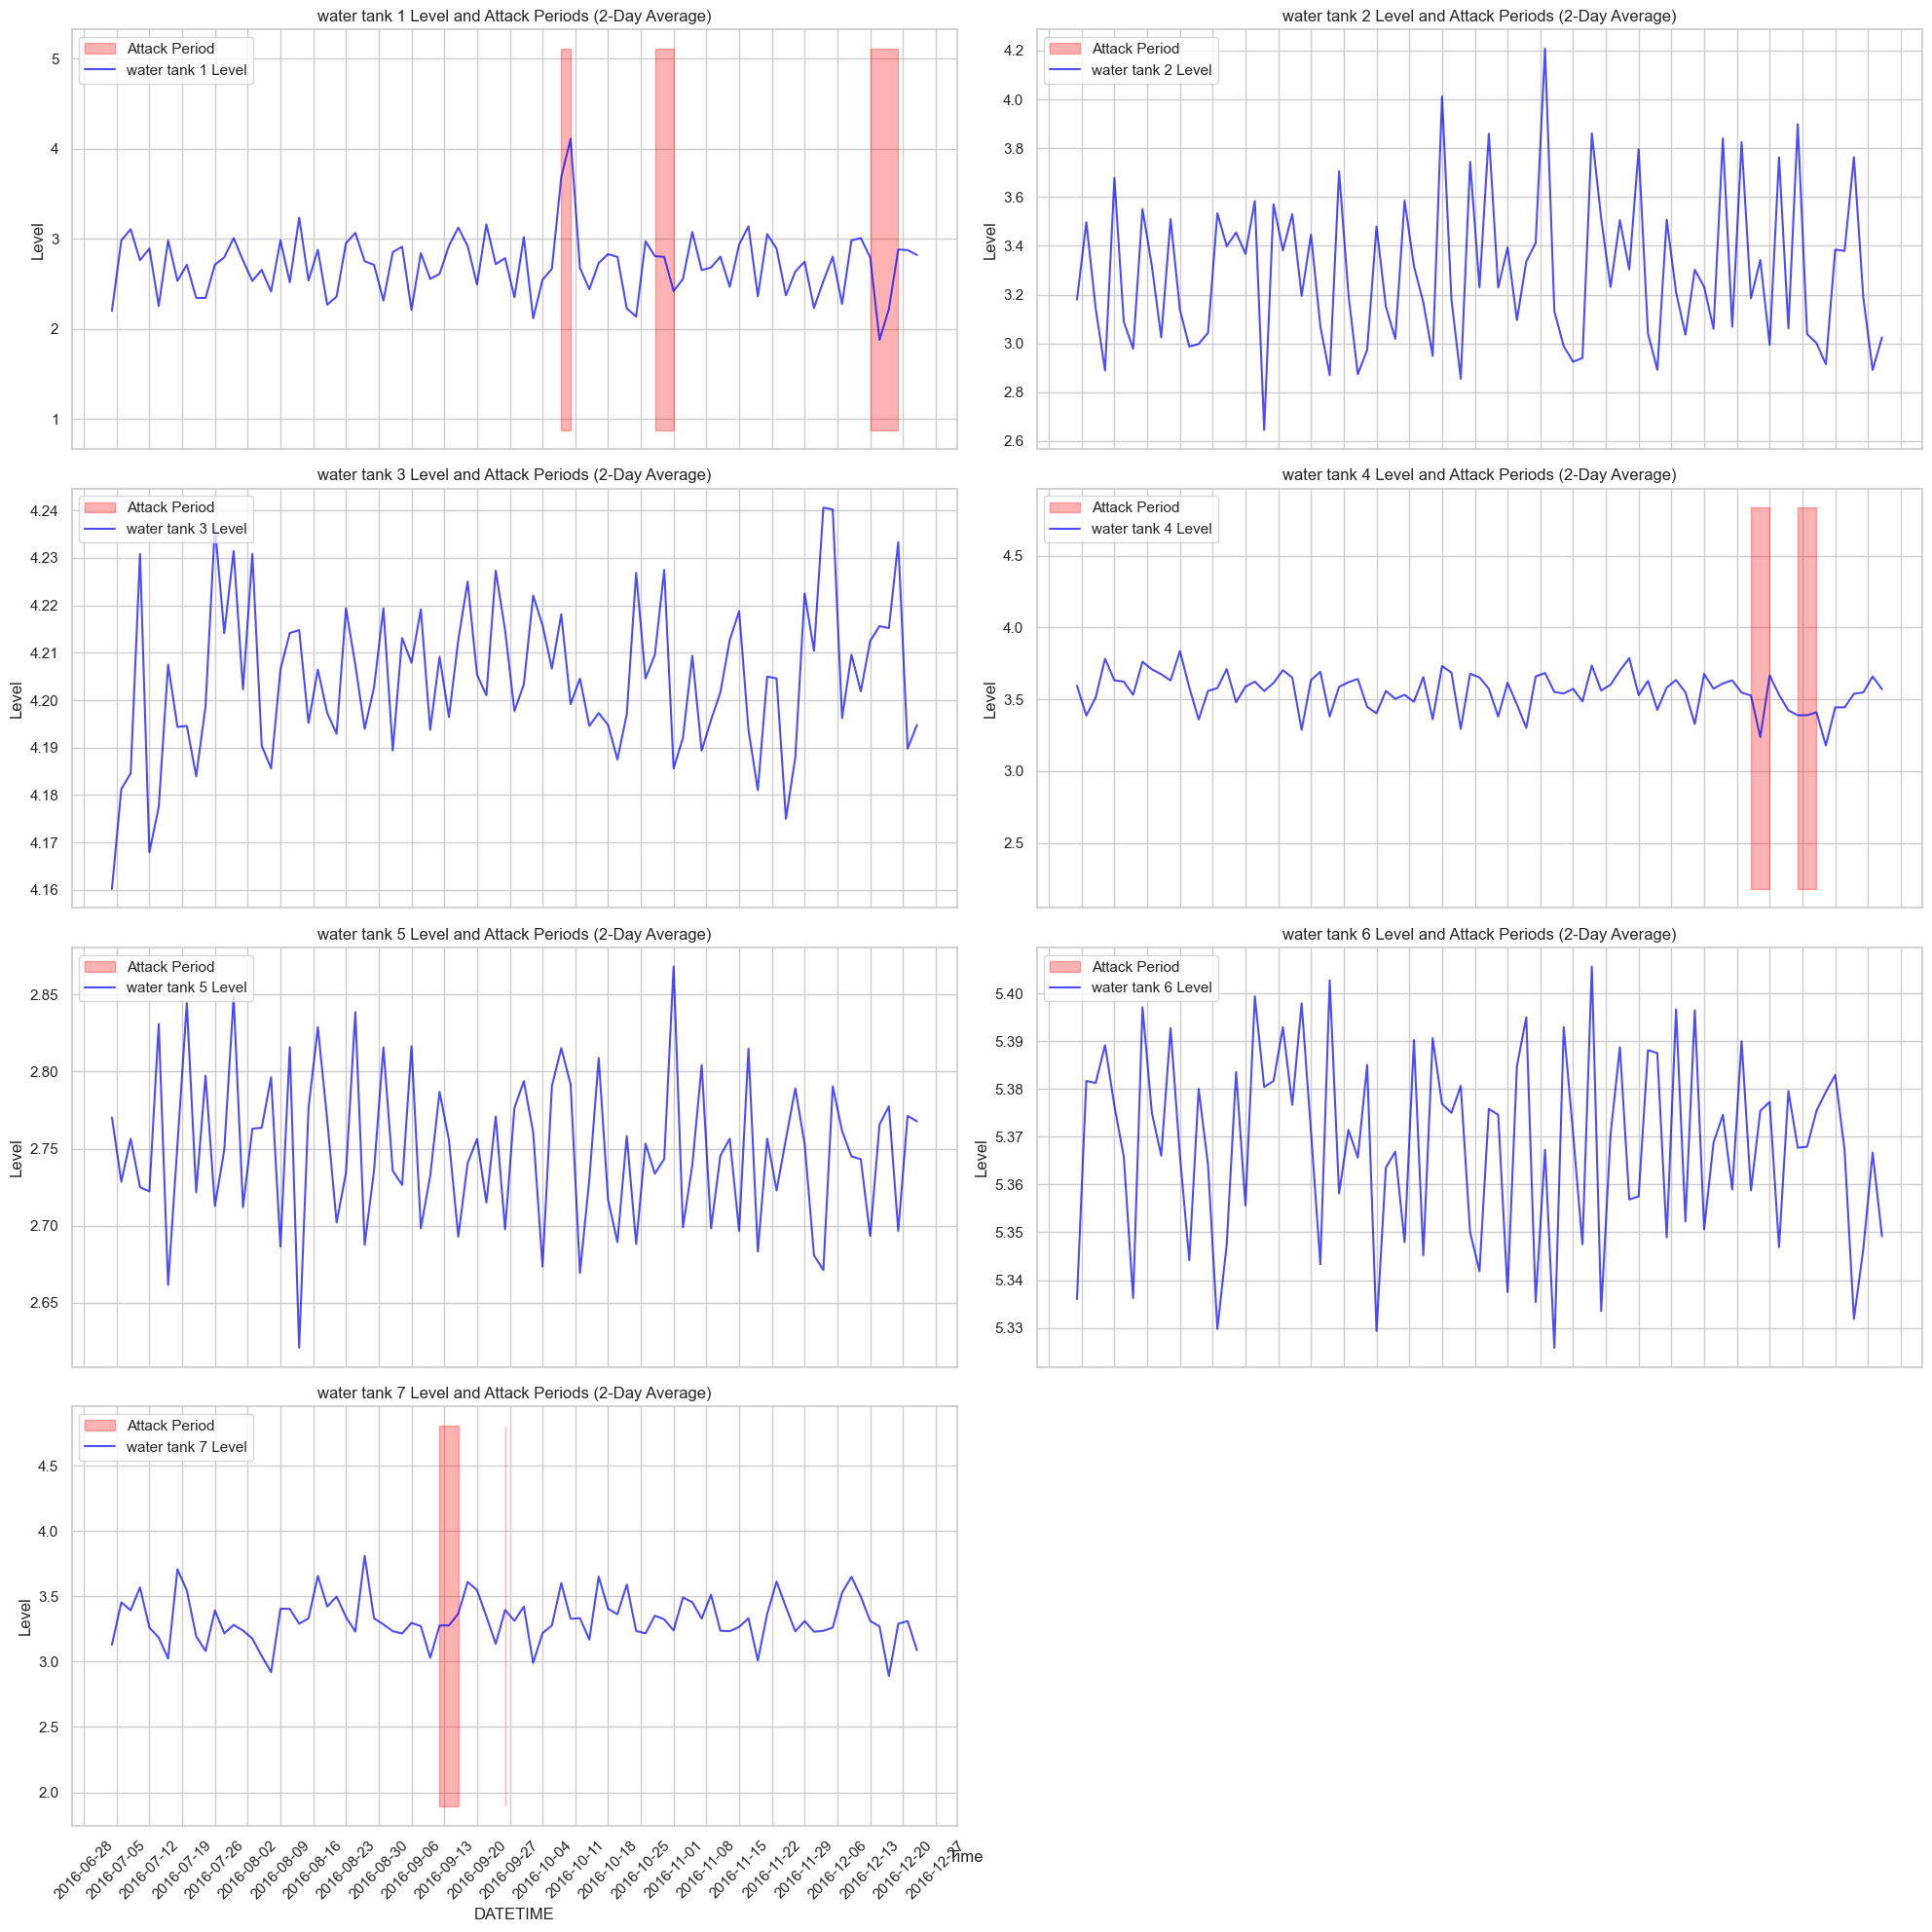

In [97]:
# Set the theme for the plots
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(20, 20), sharex=True)
axes = axes.flatten()  # Flatten the array of axes for easy iteration

weekly_data = batadal_data_wth_attack.resample('2D', on='DATETIME').mean().iloc[:-1]
weekly_data.reset_index(inplace=True)  # Reset the index to make 'DATETIME' a column

# Iterate over T1 to T7 to create individual plots on a 2-column grid
for i in range(1, 8):
    # Define the water tank column and attack flag column
    water_tank_col = f'L_T{i}'
    attack_flag_col = f'T{i}_ATT_FLAG'
    
    # Highlight the periods of attack in red across the entire y-axis range
    axes[i-1].fill_between(
        weekly_data['DATETIME'],
        weekly_data[water_tank_col].min() - 1,  # Fill from below the minimum y value
        weekly_data[water_tank_col].max() + 1,  # Fill to above the maximum y value
        where=weekly_data[attack_flag_col] > 0,
        color='red',
        alpha=0.3,
        label='Attack Period'
    )
    
    # Plot the water tank level over time
    sns.lineplot(
        ax=axes[i-1],
        x=weekly_data['DATETIME'],
        y=weekly_data[water_tank_col],
        label=f'water tank {i} Level',
        color='blue',
        alpha=0.7  # Add transparency to the line
    )
    
    # Add titles and labels
    axes[i-1].set_title(f'water tank {i} Level and Attack Periods (2-Day Average)')
    axes[i-1].set_ylabel('Level')
    axes[i-1].legend(loc='upper left')
    axes[i-1].xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
    axes[i-1].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    axes[i-1].tick_params(axis='x', rotation=45)

# Remove the last empty subplot if needed
fig.delaxes(axes[-1])

# Add a common x-axis label
fig.text(0.5, 0.04, 'Time', ha='center')

# Adjust layout for better fit
plt.tight_layout()
plt.show()

## First analysis on a somehow naive attempt

The initial observation suggests that it may not be possible to reliably detect attacks solely based on visual inspection of the water tank levels (the blue curve). Worse is, these levels can be compromised or falsified during an attack, making them unreliable for direct anomaly detection.

To address this, I propose a two-step approach:

### 1/ Build a Predictive Model for Expected Component Values

The goal is to create a predictive algorithm that estimates the “expected” value of each system component based on the state of all other components. This model will serve as a baseline to represent normal operating conditions and identify deviations. To simplify the issue, **we will only focus on the T1 surounding system** from here onward.

Approach:

- Supervised Learning Model: Implement regression-based models, such as linear regression, Random Forest Regressor, or more sophisticated models like neural networks, to predict the expected values of each component.
- Features: Use other system components (sensors, valves, pumps, etc.) as input features for the predictive model.
- Training Data: Train the model using data from periods known to be free of attacks to ensure it learns the system’s normal behavior.

### 2/ Measure Deviations to Detect Anomalies

Once the expected values are established, the next step is to measure the deviation between predicted and actual component values. Significant deviations can indicate anomalies that may be linked to attacks or system compromises.

Approach:

- Deviation Calculation: Compute metrics such as Mean Absolute Error (MAE) or Root Mean Square Error (RMSE) to quantify the difference between predicted and observed values.
- Anomaly Threshold: Define a threshold for deviation above which the behavior is flagged as anomalous. This threshold can be based on the distribution of errors during normal periods.
- Dissent Indicator: Create a composite metric that aggregates deviations across all components to signal potential attack periods.

Practical Implementation:

1.	Model Training: Train predictive models for each critical component using data from attack-free periods.
2.	Real-Time Detection: Calculate the deviation between actual and predicted values in real-time or over defined intervals. Mark periods with significant deviations as suspicious.
3.	Validation: Compare flagged periods of high deviation with known attack periods to assess the approach’s effectiveness.

This method not only identifies anomalies but also tests the reliability of sensor data, especially in environments that may be compromised. Large deviations between expected and actual values can highlight potential tampering or manipulation during an attack.

In [111]:
from collections import defaultdict, deque

# Step 1: Read the .INP file and construct the graph
file_path = './CTOWN.INP'
graph = defaultdict(list)

with open(file_path, 'r') as file:
    lines = file.readlines()

# Construct the graph from the [PIPES], [CONTROLS], and [JUNCTIONS] sections
in_pipes_section = False
in_controls_section = False
in_junctions_section = False

junctions = set()  # Set to store all junction IDs

for line in lines:
    line = line.strip()
    
    if line == "[PIPES]":
        in_pipes_section = True
        continue
    if line == "[CONTROLS]":
        in_pipes_section = False
        in_controls_section = True
        continue
    if line == "[JUNCTIONS]":
        in_controls_section = False
        in_junctions_section = True
        continue
    if line.startswith("[") and line not in ["[PIPES]", "[CONTROLS]", "[JUNCTIONS]"]:
        in_pipes_section = False
        in_controls_section = False
        in_junctions_section = False
    
    # Construct the graph from the [PIPES] section
    if in_pipes_section and line and not line.startswith(";"):
        parts = line.split()
        if len(parts) >= 3:
            node1, node2 = parts[1], parts[2]
            graph[node1].append(node2)
            graph[node2].append(node1)
    
    # Include pump actuators in the graph based on the [CONTROLS] section
    if in_controls_section and "LINK" in line and "NODE" in line:
        parts = line.split()
        pump = parts[1]  # The pump actuator
        node = parts[4]  # The node controlling the pump
        graph[node].append(pump)
        graph[pump].append(node)
    
    # Collect junctions from the [JUNCTIONS] section
    if in_junctions_section and line and not line.startswith(";"):
        parts = line.split()
        if len(parts) > 0:
            junction_id = parts[0]
            junctions.add(junction_id)
            graph[junction_id]  # Add junction to the graph as a node

# Step 2: Find all neighbors by level using BFS
def find_neighbors_by_level(graph, start_node):
    visited = set()
    queue = deque([(start_node, 0)])  # (node, level)
    levels = defaultdict(list)

    while queue:
        node, level = queue.popleft()
        if node not in visited:
            visited.add(node)
            levels[level].append(node)
            for neighbor in graph[node]:
                if neighbor not in visited:
                    queue.append((neighbor, level + 1))

    return levels

# Find all neighbors of T1 by level
neighbors_by_level = find_neighbors_by_level(graph, 'T1')

# Step 3: Check if components are in batadal_data_wth_attack using naming conventions
prefixes = ['L_', 'S_', 'F_', 'P_']
batadal_columns = batadal_data_wth_attack.columns

# Function to check if a component is present in batadal_data_wth_attack columns
def is_component_in_batadal(component, batadal_columns):
    for prefix in prefixes:
        if f"{prefix}{component}" in batadal_columns:
            return True
    return False

# Create a DataFrame to show the results
data = []
for level, components in neighbors_by_level.items():
    for component in components:
        in_batadal = is_component_in_batadal(component, batadal_columns)
        data.append({"Component": component, "Level": level, "In Batadal": in_batadal})

neighbors_df = pd.DataFrame(data)

# Filter and display only components present in batadal_data_wth_attack
neighbors_in_batadal_df = neighbors_df[neighbors_df["In Batadal"] == True]

# Display the filtered DataFrame
print(neighbors_in_batadal_df)

    Component  Level  In Batadal
0          T1      0        True
41       J302     10        True
52       J307     11        True
95        J14     16        True
103      J422     17        True
131        T2     20        True
133      J289     20        True
139      J300     21        True
148      J269     25        True


In [112]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error, r2_score
import numpy as np

# Charger les données pertinentes en se basant sur neighbors_in_batadal_df
# Extraire les composants présents dans batadal_data_wth_attack
components = neighbors_in_batadal_df['Component'].tolist()
columns_of_interest = ['DATETIME', 'L_T1'] + [f'P_{comp}' for comp in components if comp != 'T1']

# Filtrer les colonnes dans batadal_data_wth_attack
data = batadal_data_wth_attack[columns_of_interest].copy()

# Ajouter des pondérations basées sur le niveau
level_weights = {f'P_{row["Component"]}': 1/row["Level"] for _, row in neighbors_in_batadal_df.iterrows()}
level_weights['L_T1'] = 1  # Pondération pour T1 (niveau 0)

# Appliquer les pondérations aux colonnes
for col in level_weights:
    if col in data.columns:
        data[col] = data[col] * level_weights[col]

# Préparer les données pour la régression
X = data.drop(columns=['DATETIME', 'L_T1'])  # Variables explicatives
y = data['L_T1']  # Variable cible

# Normaliser les données avec StandardScaler (centrée réduite)
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)

# Diviser les données en ensemble d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=0.3, random_state=42)

# Modélisation avec régression linéaire
model = LinearRegression()
model.fit(X_train, y_train)

# Prédictions et évaluation
y_pred = model.predict(X_test)
rmse = np.sqrt(root_mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

# Afficher les résultats
print("RMSE:", rmse)
print("R² Score:", r2)

# Afficher les coefficients de la régression
coefficients = pd.DataFrame({'Feature': X.columns, 'Coefficient': model.coef_})
print(coefficients)

KeyError: "['P_T2'] not in index"